#Librerias

In [2]:
# Importamos las bibliotecas requeridas.
!pip install prophet
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.dates as mdates
from statsmodels.graphics.tsaplots import month_plot, quarter_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

Nombre.- Héctor García Domínguez

Matricula.- A01731509

#Info Inicial

In [3]:
#Omitamos los Warnings por el momento:
import warnings
warnings.filterwarnings('ignore')

In [4]:
ticker_symbol = 'NVDA'
#ticker_symbol = 'AAPL'
data = yf.download(ticker_symbol, period='5y')
data.to_csv('historical_data.csv')   # Guardamos los datos

# Eliminar las primeras 2 filas vacías
data = data.iloc[2:]


data = data.reset_index()
data.columns = ['Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
data['Date'] = pd.to_datetime(data['Date'])
data = data[['Date', 'Adj Close']]
data.set_index('Date', inplace=True)


[*********************100%***********************]  1 of 1 completed


In [5]:
data.head()

,Adj Close
Date,
2019-11-15 00:00:00+00:00,5.080041
2019-11-18 00:00:00+00:00,5.281312
2019-11-19 00:00:00+00:00,5.174581
2019-11-20 00:00:00+00:00,5.253945
2019-11-21 00:00:00+00:00,5.229066


In [6]:
data.index

DatetimeIndex(['2019-11-15 00:00:00+00:00', '2019-11-18 00:00:00+00:00',
               '2019-11-19 00:00:00+00:00', '2019-11-20 00:00:00+00:00',
               '2019-11-21 00:00:00+00:00', '2019-11-22 00:00:00+00:00',
               '2019-11-25 00:00:00+00:00', '2019-11-26 00:00:00+00:00',
               '2019-11-27 00:00:00+00:00', '2019-11-29 00:00:00+00:00',
               ...
               '2024-10-30 00:00:00+00:00', '2024-10-31 00:00:00+00:00',
               '2024-11-01 00:00:00+00:00', '2024-11-04 00:00:00+00:00',
               '2024-11-05 00:00:00+00:00', '2024-11-06 00:00:00+00:00',
               '2024-11-07 00:00:00+00:00', '2024-11-08 00:00:00+00:00',
               '2024-11-11 00:00:00+00:00', '2024-11-12 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='Date', length=1256, freq=None)

In [7]:
print(data.columns)  # Esto mostrará los nombres de las columnas
print(data.head())   # Para ver las primeras filas del archivo

Index(['Adj Close'], dtype='object')
                           Adj Close
Date                                
2019-11-15 00:00:00+00:00   5.080041
2019-11-18 00:00:00+00:00   5.281312
2019-11-19 00:00:00+00:00   5.174581
2019-11-20 00:00:00+00:00   5.253945
2019-11-21 00:00:00+00:00   5.229066


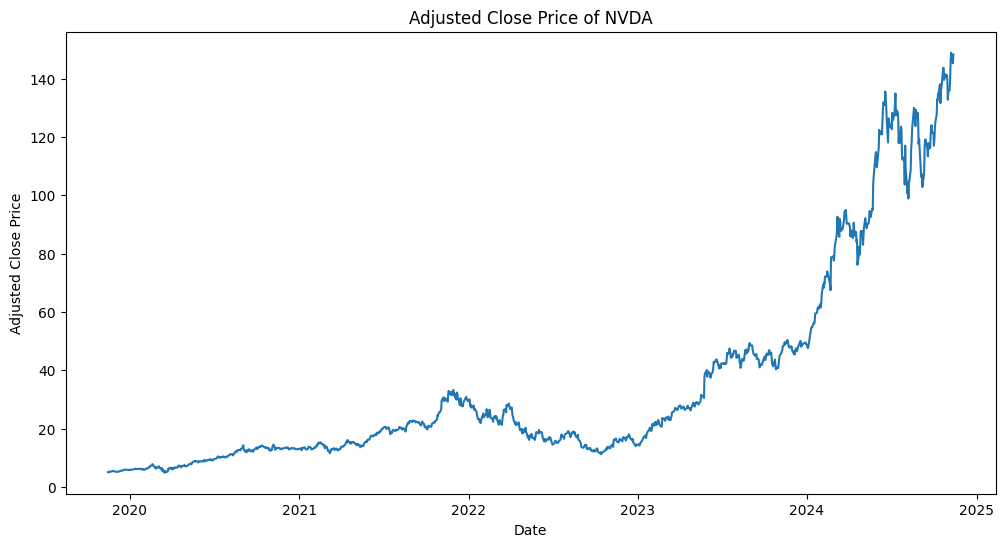

In [8]:
plt.figure(figsize=(12, 6))
sns.lineplot(x=data.index, y=data['Adj Close'].squeeze())  # Usar .squeeze() para asegurar que es 1D
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.title(f'Adjusted Close Price of {ticker_symbol}')
plt.show()

#Concepto - Adj Close

Significado de "Adj Close"


La columna "Adj Close" (Adjusted Close o Cierre Ajustado) representa el precio de cierre de una acción después de ajustar los eventos corporativos que puedan afectar su valor. Estos ajustes suelen incluir dividendos, divisiones de acciones (splits), emisiones de derechos, y otros eventos similares.

A diferencia del precio de cierre "Close", que refleja el último precio al que se negoció la acción en un día específico, el "Adj Close" ajusta ese valor para que sea más representativo de la rentabilidad real para los accionistas. Esto hace que el "Adj Close" sea particularmente útil en análisis históricos, ya que permite comparar los precios a lo largo del tiempo sin que estos cambios estructurales distorsionen los valores.

Incluir esta explicación en el reporte ayuda a entender por qué el "Adj Close" es más adecuado que el "Close" para estudios de rendimiento a largo plazo, como el análisis de precios históricos de las acciones.

#Preprocesamiento

In [9]:
df_temp = data.copy()
df_temp.index = pd.to_datetime(df_temp.index).tz_localize(None)  # Eliminar zona horaria
df_temp.index = df_temp.index.normalize()  # Normalizar
df_temp = df_temp.asfreq('B')
#df_temp = df_temp.rename(columns={"Date": "ds", "Adj Close": "y"})
df_temp = df_temp.fillna(method='ffill')

df_temp.index

DatetimeIndex(['2019-11-15', '2019-11-18', '2019-11-19', '2019-11-20',
               '2019-11-21', '2019-11-22', '2019-11-25', '2019-11-26',
               '2019-11-27', '2019-11-28',
               ...
               '2024-10-30', '2024-10-31', '2024-11-01', '2024-11-04',
               '2024-11-05', '2024-11-06', '2024-11-07', '2024-11-08',
               '2024-11-11', '2024-11-12'],
              dtype='datetime64[ns]', name='Date', length=1303, freq='B')

In [10]:
df_temp = df_temp.sort_index()

test_size = 20
test = df_temp.iloc[-test_size:]  # Últimos 20 datos
train = df_temp.iloc[:-test_size]  # Todos los datos anteriores a los últimos 20

print(f'Tamaño del conjunto de entrenamiento: {train.shape}')
print(f'Tamaño del conjunto de prueba: {test.shape}')

Tamaño del conjunto de entrenamiento: (1283, 1)
Tamaño del conjunto de prueba: (20, 1)


In [11]:
trainp = train.rename(columns={"Adj Close": "y"})
trainp = trainp.reset_index()
trainp = trainp.rename(columns={"Date": "ds"})

In [12]:
train.head()

,Adj Close
Date,
2019-11-15,5.080041
2019-11-18,5.281312
2019-11-19,5.174581
2019-11-20,5.253945
2019-11-21,5.229066


In [13]:
# Seleccionamos solo la columna "Adj Close"
adj_close_data = data['Adj Close']

# Dividimos los datos: último 20 valores para Test, el resto para Train
train_data = adj_close_data[:-20]
test_data = adj_close_data[-20:]

# Mostramos las dimensiones de cada conjunto para verificar
print(f"Tamaño del conjunto de entrenamiento (Train): {train_data.shape[0]}")
print(f"Tamaño del conjunto de prueba (Test): {test_data.shape[0]}")


Tamaño del conjunto de entrenamiento (Train): 1236
Tamaño del conjunto de prueba (Test): 20


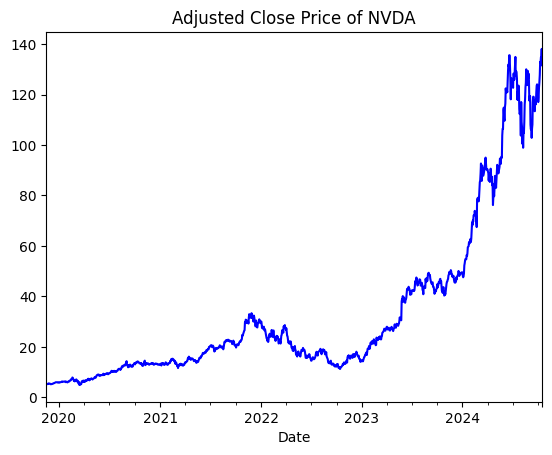

In [14]:
train['Adj Close'].plot(title=f'Adjusted Close Price of {ticker_symbol}', style='-b')
plt.show()

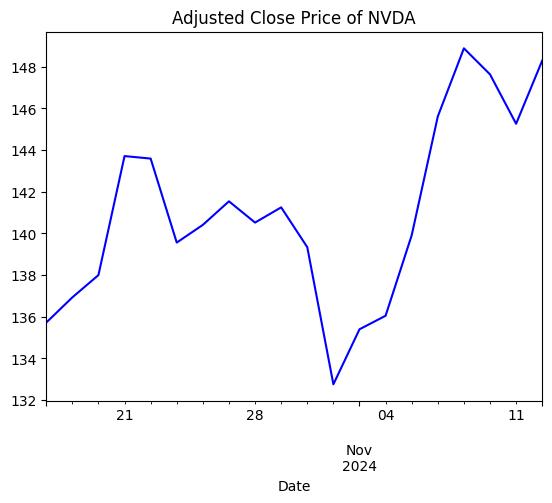

In [15]:
test['Adj Close'].plot(title=f'Adjusted Close Price of {ticker_symbol}', style='-b')
plt.show()

# #1 Modelo Ingenuo

In [16]:
test['Adj Close'].values

array([135.72000122, 136.92999268, 138.        , 143.71000671,
       143.58999634, 139.55999756, 140.41000366, 141.53999329,
       140.52000427, 141.25      , 139.33999634, 132.75999451,
       135.3999939 , 136.05000305, 139.91000366, 145.61000061,
       148.88000488, 147.63000488, 145.25999451, 148.28999329])

In [17]:
history = [x for x in train['Adj Close'].values]   # Definimos "history" donde de manera incremental se irán agregando registros mensuales.
predictions = list()    # Lista que contendrá las predicciones del modelo ingenuo.

for i in range(len(test['Adj Close'])):
  # Obtenemos las predicciones:
  yhat = history[-1]   # La primera vez, tomamos el último dato del Train, en las siguientes, se van agregando los datos de Test.
  predictions.append(yhat)

  # Observaciones-registros reales:
  obs = test.iloc[i]['Adj Close']   # Ahora vamos tomando los datos de Test.
  history.append(obs)  # Vamos agregando a "history" (que ya tiene todo los de Train) en cada iteración, un dato más de los de Test.
  print('>Esperado-real = %3d, Predicción = %.3f' % (obs, yhat))


# Calculamos la raíz del error cuadrático medio (RMSE):
rmse = np.sqrt(mean_squared_error(test['Adj Close'].values, predictions))
print('\nError-Modelo-Naive: RMSE: %.3f' % rmse)

>Esperado-real = 135, Predicción = 131.600
>Esperado-real = 136, Predicción = 135.720
>Esperado-real = 138, Predicción = 136.930
>Esperado-real = 143, Predicción = 138.000
>Esperado-real = 143, Predicción = 143.710
>Esperado-real = 139, Predicción = 143.590
>Esperado-real = 140, Predicción = 139.560
>Esperado-real = 141, Predicción = 140.410
>Esperado-real = 140, Predicción = 141.540
>Esperado-real = 141, Predicción = 140.520
>Esperado-real = 139, Predicción = 141.250
>Esperado-real = 132, Predicción = 139.340
>Esperado-real = 135, Predicción = 132.760
>Esperado-real = 136, Predicción = 135.400
>Esperado-real = 139, Predicción = 136.050
>Esperado-real = 145, Predicción = 139.910
>Esperado-real = 148, Predicción = 145.610
>Esperado-real = 147, Predicción = 148.880
>Esperado-real = 145, Predicción = 147.630
>Esperado-real = 148, Predicción = 145.260

Error-Modelo-Naive: RMSE: 3.169


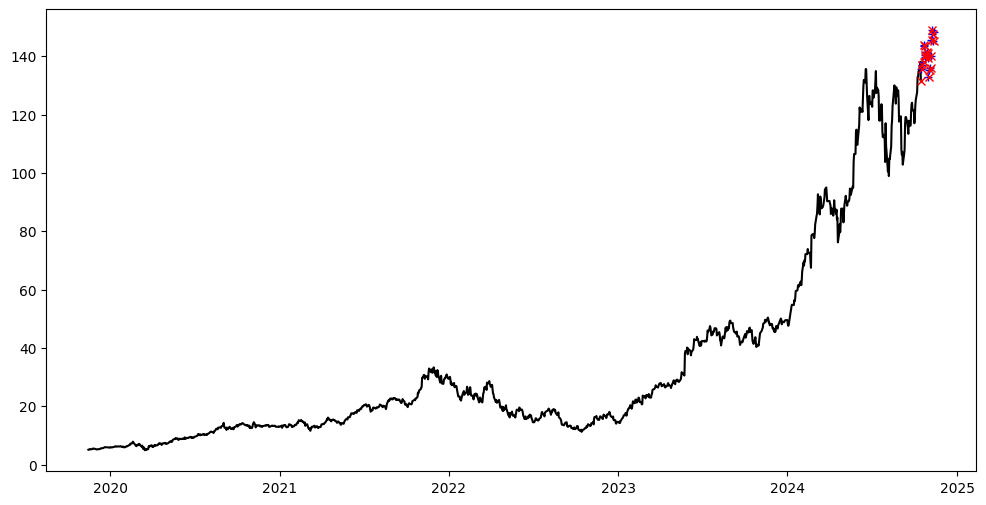

In [18]:
fig, ax = plt.subplots(figsize=(12, 6))
ax = plt.plot(train['Adj Close'], '-k') #Datos de entrenamiento (historicos)
ax = plt.plot(test['Adj Close'], '+b') #Datos de prueba reales (los del ultimo año a predecir)
ax = plt.plot(test.index, predictions, 'xr') #Predicciones del siguiente modelo ingenuo para el ultimo año

# #2 Modelo Arima

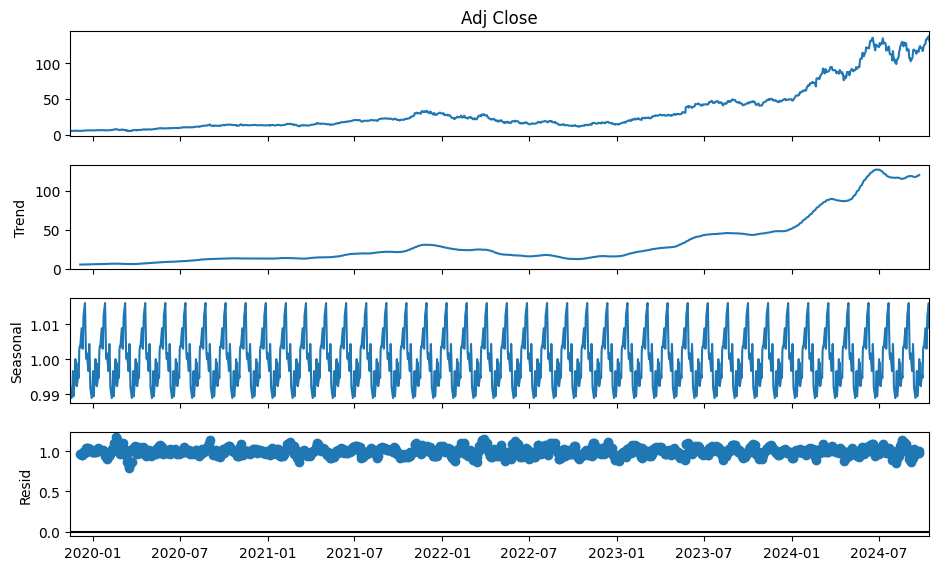

In [19]:
# Descomposición estacional con periodo de 30 días sin resampleo
decomposition = seasonal_decompose(train['Adj Close'], model='multiplicative', period=30)

fig = decomposition.plot()
fig.set_size_inches(10, 6)
plt.show()

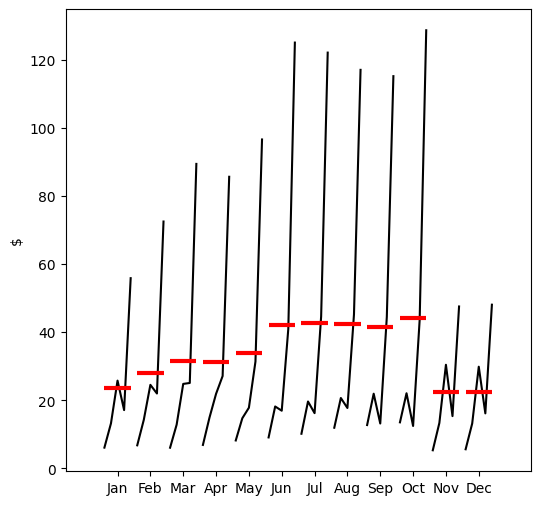

In [20]:
# Gráfica para detección de estacionalidad mensual:
fig = month_plot(train['Adj Close'].resample('M').mean(), ylabel='$')
fig.set_size_inches(6,6)
plt.show()

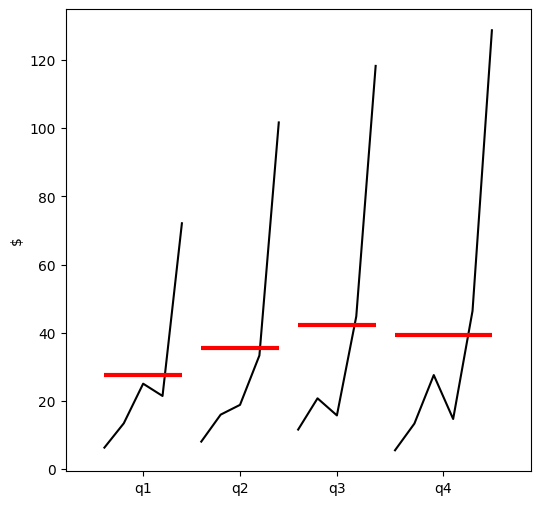

In [21]:
#Gráfica para detección de estacionalidad trimestral:
fig = quarter_plot(train['Adj Close'].resample('Q').mean(), ylabel='$')
fig.set_size_inches(6,6)
plt.show()

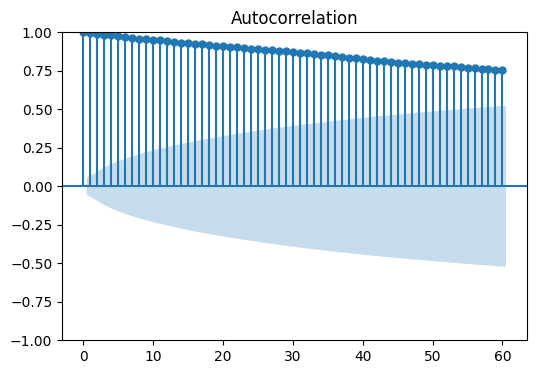

In [22]:
# Gráfico de Autocorrelación (ACF: Auto-Correlation-Function)
fig,ax = plt.subplots(figsize = (6,4))
plot_acf(train['Adj Close'], lags=60, ax=ax)   # Eliges el número de unidades (meses) desfasadas. El número de "lags" es el número
plt.show()                          # que define la partición en el eje horizontal. El área no sombreada nos habla de
                                    # la cantidad de períodos de tiempo hacia atrás cuya información proporcionada es
                                    # significativa para la predicción futura.
                                    # También nos ayuda a detectar periodicidades, como en este caso que se observa a 13 meses, aprox.

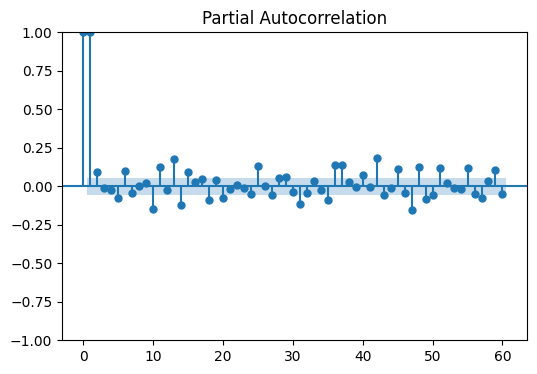

In [23]:
# Gráfico de Autocorrelación Parcial (PACF):
fig, ax = plt.subplots(figsize = (6,4))
plot_pacf(train['Adj Close'], lags = 60, ax = ax, method="ols")   # ols: regression of time series on lags of it an on constant. predetrminado method="ywm"
plt.show()

In [24]:
# Lo primero es para quitar la estacionalidad y transformar un problema
# de tipo no-estacionario (SARIMA) en uno estacionario (ARIMA):

# Diferencia de datos consecutivos en el tiempo
# y podemos ahora usar ARIMA:
def difference(dataset, interval=1):
  diff = list()

  for i in range(interval, len(dataset)):
    value = dataset[i] - dataset[i - interval]
    diff.append(value)

  return np.array(diff)



# Invierte las diferencias anteriores, es decir, nos regresa la estacionalidad:
def inverse_difference(history, yhat, interval=1):
  return yhat + history[-interval]


In [25]:
# Definamos la siguiente lista de registros de pasajeros en el tiempo:
history = [x for x in train.loc[:,'Adj Close'].values]   # train-ndarray : columna solo con los registros de pasajeros "y".
                               # history-list : lista con los datos del train.

predictions = list()   # Para incluir las predicciones que vaya generando el modelo.

for i in range(len(test['Adj Close'])):
  #
  days = 12
  diff = difference(history, days)    # diff-list: lista de los datos de diferencias para transformar SARIMA en ARIMA.

  # Generamos el modelo.
  #model = ARIMA(diff, order=(3,0,13),) # Si aplicamos diff, entonces d=0 es aplicable.
  model = ARIMA(diff, order=(1,0,1),)
  model_fit = model.fit(method_kwargs={'maxiter':300})  # Aumentar las iteraciones para evitar el WarningConvergence.

  yhat = model_fit.forecast()[0]   # prediccions (yhat) de cada registro, es un solo número flotante.
  yhat = inverse_difference(history, yhat, days)    # El "history" sigue siendo la lista de arriba.
                                                              # El nuevo "yhat" es cada un nuevo valor (float) de predicción.
  predictions.append(yhat)  # predictions-list : lista que se va incrementando al ir agregando cada predicción nueva.

  # Observaciones-reales:
  obs = test.iloc[i]['Adj Close']   #  cada dato es un flotante.
  history.append(obs)   #  history-list : se va incrementado a partir del Train con los registros-observaciones reales.

  print('>Esperado-real = %3d, Predicción = %.3f' % (obs, yhat))

# Error RMSE:
rmse = np.sqrt(mean_squared_error(test['Adj Close'].values, predictions))
print('\nError-Modelo-ARIMA: RMSE: %.3f' % rmse)

>Esperado-real = 135, Predicción = 131.137
>Esperado-real = 136, Predicción = 129.826
>Esperado-real = 138, Predicción = 136.701
>Esperado-real = 143, Predicción = 140.514
>Esperado-real = 143, Predicción = 144.024
>Esperado-real = 139, Predicción = 145.120
>Esperado-real = 140, Predicción = 144.388
>Esperado-real = 141, Predicción = 140.000
>Esperado-real = 140, Predicción = 142.964
>Esperado-real = 141, Predicción = 140.362
>Esperado-real = 139, Predicción = 144.028
>Esperado-real = 132, Predicción = 133.268
>Esperado-real = 135, Predicción = 136.931
>Esperado-real = 136, Predicción = 136.867
>Esperado-real = 139, Predicción = 137.361
>Esperado-real = 145, Predicción = 145.351
>Esperado-real = 148, Predicción = 145.416
>Esperado-real = 147, Predicción = 144.231
>Esperado-real = 145, Predicción = 147.651
>Esperado-real = 148, Predicción = 146.300

Error-Modelo-ARIMA: RMSE: 3.197


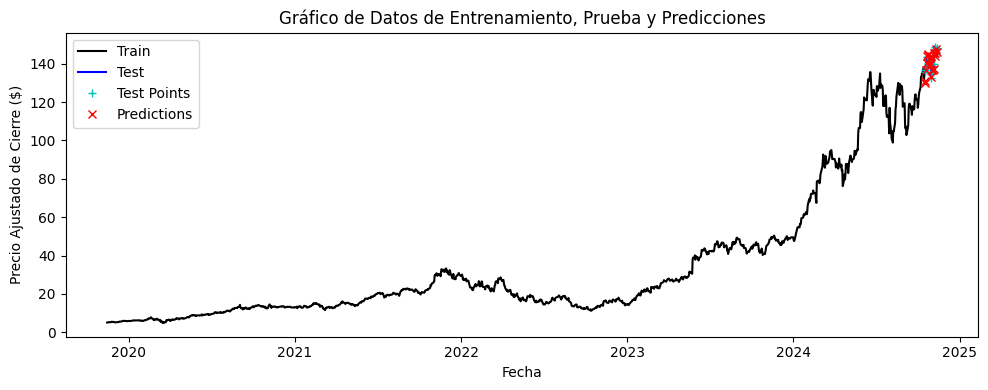

In [26]:
fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(train.index, train['Adj Close'], '-k', label='Train')  # Línea negra para los datos de entrenamiento
ax.plot(test.index, test['Adj Close'], '-b', label='Test')  # Línea azul para los datos de prueba
ax.plot(test.index, test['Adj Close'], '+c', label='Test Points')  # Puntos cyan para los datos de prueba

ax.plot(test.index, predictions, 'xr', label='Predictions')  # Cruces rojas para las predicciones

ax.set_title('Gráfico de Datos de Entrenamiento, Prueba y Predicciones')
ax.set_xlabel('Fecha')
ax.set_ylabel('Precio Ajustado de Cierre ($)')

ax.legend()

plt.tight_layout()
plt.show()


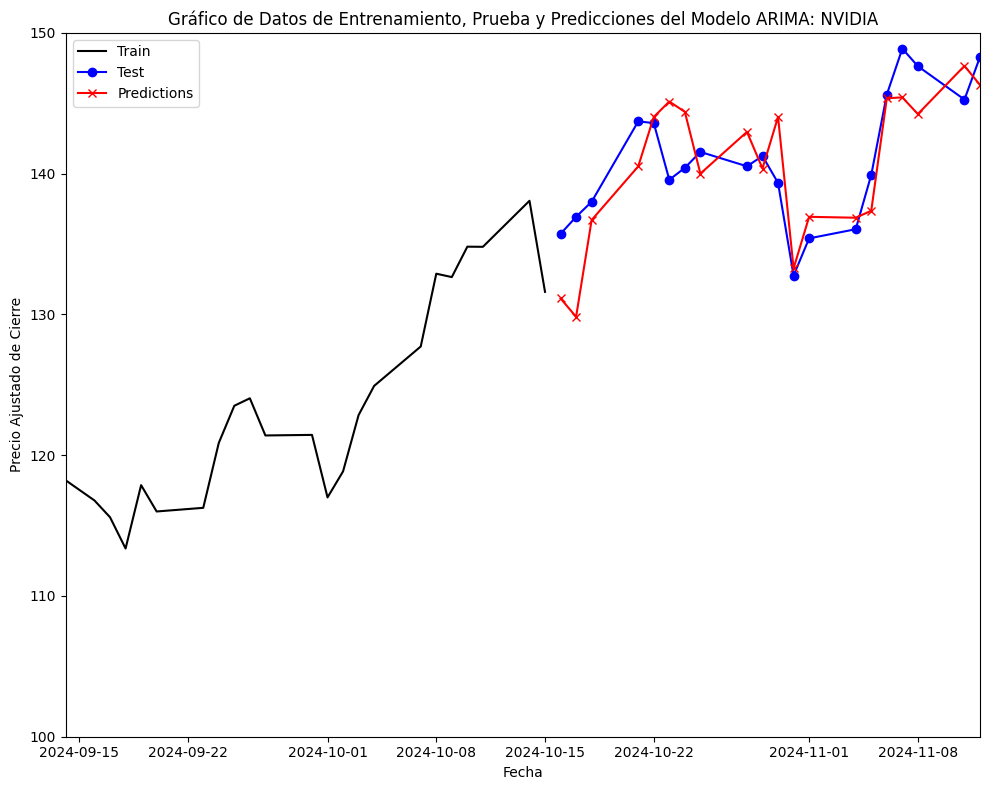

In [27]:
fig, ax = plt.subplots(figsize=(10, 8))

# Graficar los datos de entrenamiento, prueba y predicciones
ax.plot(train['Adj Close'], 'k-', label='Train')      # Línea negra continua para el entrenamiento
ax.plot(test['Adj Close'], 'b-o', label='Test')        # Línea azul continua para el conjunto de prueba
ax.plot(test.index, predictions, 'r-x', label='Predictions')  # Cruces rojas para las predicciones

last_year = pd.to_datetime('today') - pd.DateOffset(days=60)
ax.set_xlim(last_year, test.index[-1])

ax.set_ylim(100, 150)
# Añadir leyenda y etiquetas de ejes
ax.legend()
ax.set_title('Gráfico de Datos de Entrenamiento, Prueba y Predicciones del Modelo ARIMA: NVIDIA')
ax.set_xlabel('Fecha')
ax.set_ylabel('Precio Ajustado de Cierre')

# Mostrar la gráfica
plt.tight_layout()
plt.show()


# #3 Modelo Propeth

In [28]:
train = data.iloc[0:-12,:]
test = data.iloc[-12:,:]

In [29]:
data.head()

,Adj Close
Date,
2019-11-15 00:00:00+00:00,5.080041
2019-11-18 00:00:00+00:00,5.281312
2019-11-19 00:00:00+00:00,5.174581
2019-11-20 00:00:00+00:00,5.253945
2019-11-21 00:00:00+00:00,5.229066


In [30]:
trainp = train.rename(columns={"Adj Close": "y"})
trainp = trainp.reset_index()
trainp = trainp.rename(columns={"Date": "ds"})
# Convertir la columna 'ds' al formato deseado sin la zona horaria
trainp['ds'] = pd.to_datetime(trainp['ds']).dt.strftime('%Y-%m-%d')  # Cambia el formato a 'YYYY-MM-DD'

# Verifica el cambio
trainp.head()


,ds,y
0,2019-11-15,5.080041
1,2019-11-18,5.281312
2,2019-11-19,5.174581
3,2019-11-20,5.253945
4,2019-11-21,5.229066


In [31]:
# Calculamos el error RMSE:

testp = test.rename(columns={"Adj Close": "y"})
testp = testp.reset_index()
testp = testp.rename(columns={"Date": "ds"})
# Cambiar el formato de la columna 'ds' a 'YYYY-MM-DD'
testp['ds'] = testp['ds'].dt.strftime('%Y-%m-%d')
testp

,ds,y
0,2024-10-28,140.520004
1,2024-10-29,141.250000
2,2024-10-30,139.339996
3,2024-10-31,132.759995
4,2024-11-01,135.399994
5,2024-11-04,136.050003
6,2024-11-05,139.910004
7,2024-11-06,145.610001
8,2024-11-07,148.880005
9,2024-11-08,147.630005


In [32]:
model = Prophet(
    seasonality_mode='additive',
    yearly_seasonality=False,
    changepoint_prior_scale=0.1,
    seasonality_prior_scale=0.5
)

model.fit(trainp)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3cyy1t0l/vmjhqpa2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3cyy1t0l/wwj24kqa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71256', 'data', 'file=/tmp/tmp3cyy1t0l/vmjhqpa2.json', 'init=/tmp/tmp3cyy1t0l/wwj24kqa.json', 'output', 'file=/tmp/tmp3cyy1t0l/prophet_modelsdh0ipbg/prophet_model-20241113033656.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:36:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:36:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [33]:
# Calculamos el error RMSE:

pred_FP = model.predict(testp)['yhat']
rmse = np.sqrt(mean_squared_error(testp['y'], pred_FP))
print('\nError-Modelo-FacebookProphet: RMSE: %.3f' % rmse)



Error-Modelo-FacebookProphet: RMSE: 4.399


In [34]:
trainp['ds'] = pd.to_datetime(trainp['ds']).dt.date
testp['ds'] = pd.to_datetime(testp['ds']).dt.date

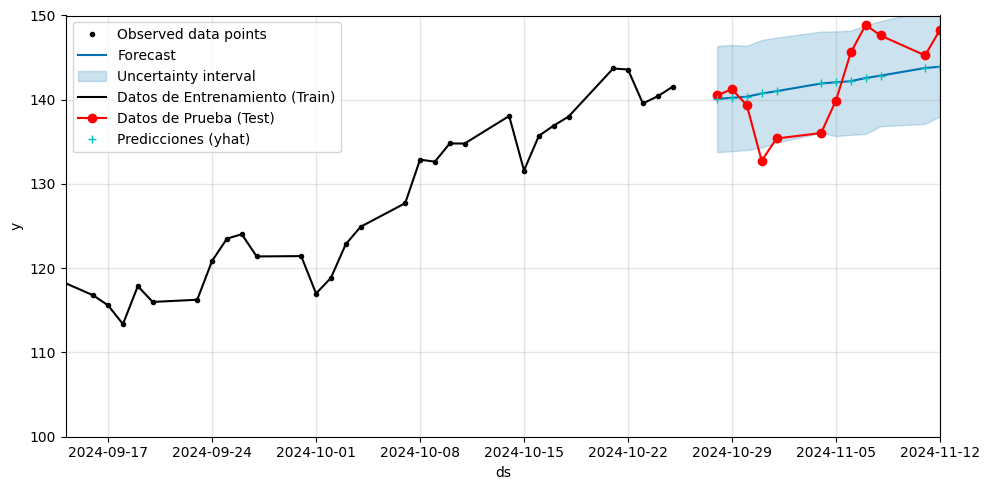

In [35]:
# Predecir con Prophet
forecast = model.predict(testp)

fig = model.plot(forecast)
fig.set_size_inches(10, 5)
ax = fig.gca()

last_year = pd.to_datetime('today') - pd.DateOffset(days=60)
ax.set_xlim(last_year, testp['ds'].max())

ax.set_ylim(100, 150)

ax.plot(trainp['ds'], trainp['y'], 'k-', label='Datos de Entrenamiento (Train)')  # Línea negra continua para los datos de entrenamiento

ax.plot(testp['ds'], testp['y'], 'r-o', label='Datos de Prueba (Test)')

ax.plot(testp['ds'], forecast['yhat'], '+c', label='Predicciones (yhat)')

ax.legend()
plt.tight_layout()
plt.show()

# #4 Modelo LSTM

In [36]:
df = pd.read_csv('historical_data.csv', skiprows=2)
df = df[['Date', 'Unnamed: 1']]
df.columns = ['ds', 'y']
df['ds'] = pd.to_datetime(df['ds']).dt.normalize().dt.tz_localize(None)
df_mensual = df.resample('M', on='ds').mean().reset_index()
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      1258 non-null   datetime64[ns]
 1   y       1258 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.8 KB


,ds,y
0,2019-11-13,5.189010
1,2019-11-14,5.219363
2,2019-11-15,5.080041
3,2019-11-18,5.281312
4,2019-11-19,5.174581


In [37]:
def preparando_datos(myData, myDate):

  # ********************* Entrenamiento ****************************

  # Los datos de entrenamiento son previos a la fecha "Date" que indiques y
  # tomarán hisotriales en este caso de 12 períodos previos.
  Train_Data = myData['y'][myData['ds'] < myDate].to_numpy()

  periodo = 12   # 12 meses al año

  Data_Train = []
  Data_Train_X = []
  Data_Train_Y = []

  for i in range(0, len(Train_Data), periodo):    # observa que va formando el Train set con historiales de 12 períodos consecutivos.
    try:
      Data_Train.append(Train_Data[i : i + periodo])
    except:
      pass


  # En ocasiones hay datos perdidos, en cuyo caso la última serie
  # de datos la eliminamos:
  if len(Data_Train[-1]) < periodo:
    Data_Train.pop(-1)


  # Hay que darle la forma (dimensionalidad) que requieren los modelos
  # de aprendizaje profundo, en particular la librería de TensorFlow:
  #     (batch_size, sequence_length, input_dimension).

  Data_Train_X = Data_Train[0 : -1]
  Data_Train_X = np.array(Data_Train_X)
  Data_Train_X = Data_Train_X.reshape((-1, periodo, 1))

  Data_Train_Y = Data_Train[1 : len(Data_Train)]
  Data_Train_Y = np.array(Data_Train_Y)
  Data_Train_Y = Data_Train_Y.reshape((-1, periodo, 1))


  # ********************* Testeo ****************************

  # Los datos de prueba (Test) son posteriores a la fecha "Date" y que es el
  # último ciclo que deseas predecir:
  Test_Data = myData['y'][myData['ds'] >= myDate].to_numpy()

  # inicialización de listas:
  Data_Test = []
  Data_Test_X = []
  Data_Test_Y = []

  for i in range(0, len(Test_Data), periodo):
    try:
      Data_Test.append(Test_Data[i : i + periodo])
    except:
      pass


  if len(Data_Test[-1]) < periodo:
    Data_Test.pop(-1)

  Data_Test_X = Data_Test[0 : -1]
  Data_Test_X = np.array(Data_Test_X)
  Data_Test_X = Data_Test_X.reshape((-1, periodo, 1))

  Data_Test_Y = Data_Test[1 : len(Data_Test)]
  Data_Test_Y = np.array(Data_Test_Y)
  Data_Test_Y = Data_Test_Y.reshape((-1, periodo, 1))


  return Data_Train_X, Data_Train_Y, Data_Test_X, Data_Test_Y

In [38]:
# Get the last date in the DataFrame
last_date = df_mensual['ds'].max()

# Calculate the threshold date as 12 months before the last date
threshold_date = last_date - pd.DateOffset(years = 2)

# Asegúrate de que la columna de fechas del DataFrame sea de tipo DateTime.
# Se generan paquetes de 12 meses. Los *_Y son los años desfasados hacia adelante
# de los *_X:

Train_X, Train_Y, Test_X, Test_Y = preparando_datos(df_mensual, threshold_date)

threshold_date

Timestamp('2022-11-30 00:00:00')

In [39]:
# Podemos definir la manera en que el tamaño de paso (learning-rate) varíe
# en cada época. Es usual definir también algunas funciones, exponenciales,
# por ejemplo. Por el momento definamos valores constantes por intervalos:

def scheduler(epoch):

  if epoch <= 100:
    lrate = 0.05
  elif epoch <= 180:
    lrate = 0.0005
  elif epoch <=190:
    lrate = 0.00005
  else:
    lrate = (10 ** -5)

  return lrate


callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 377.7046 - root_mean_squared_error: 19.4346 - val_loss: 9207.6523 - val_root_mean_squared_error: 95.9565 - learning_rate: 0.0500
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step - loss: 348.1976 - root_mean_squared_error: 18.6601 - val_loss: 8669.3779 - val_root_mean_squared_error: 93.1095 - learning_rate: 0.0500
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 258.3155 - root_mean_squared_error: 16.0722 - val_loss: 6434.3159 - val_root_mean_squared_error: 80.2142 - learning_rate: 0.0500
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 254.8666 - root_mean_squared_error: 15.9645 - val_loss: 61872.3320 - val_root_mean_squared_error: 248.7415 - learning_rate: 0.0500
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 200.6194 - root_mean_squared_error: 14.1640 - val_loss: 1517427.5000 - val_root_mean_squared_error: 1231.8391 - learning_rate: 0.0500
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss

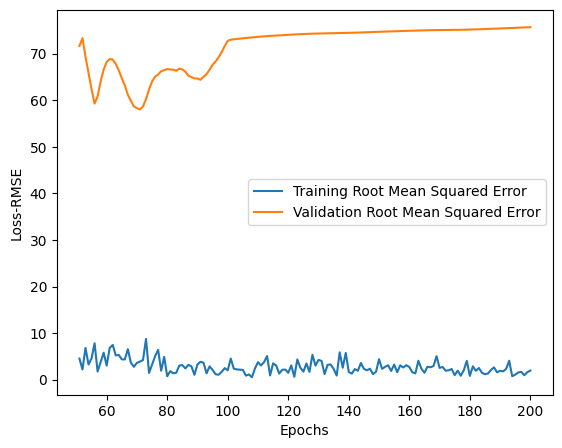

In [40]:
def myModel():

  model = tf.keras.models.Sequential([tf.keras.layers.LSTM(20, input_shape=(12, 1), activation=tf.nn.leaky_relu, return_sequences=False),
                                      tf.keras.layers.BatchNormalization(),
                                      tf.keras.layers.Dropout(0.2),
                                      #tf.keras.layers.LSTM(20, activation=tf.nn.leaky_relu),
                                      #tf.keras.layers.BatchNormalization(),
                                      #tf.keras.layers.Dropout(0.2),

                                      tf.keras.layers.Dense(200, activation=tf.nn.leaky_relu),
                                      tf.keras.layers.Dropout(0.2),
                                      #tf.keras.layers.Dense(120, activation=tf.nn.leaky_relu),


                                      tf.keras.layers.Dense(12, activation=tf.nn.leaky_relu)
                                      ])
  return model


# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


my_LSTM_model2 = myModel()

my_LSTM_model2.compile(optimizer=tf.keras.optimizers.Adam(),
                      loss='mse',    # función de costo "mse"
                      metrics=[tf.keras.metrics.RootMeanSquaredError()]   #  RMSE- despliega
                      )


H = my_LSTM_model2.fit(Train_X,
                       Train_Y,
                       epochs=200,
                       validation_data=(Test_X, Test_Y),
                       callbacks=[callback],

                       )



N = 50  # Para omitir los N primeros valores en la gráfica, que en ocasiones son
        # demasiado grandes los errores y no dejan apreciar las curvas de aprendizaje.

epochs = range(N+1, len(H.history["loss"]) + 1)

fig, ax2 = plt.subplots()
fig.set_figheight(5)
ax2.plot(epochs, H.history["root_mean_squared_error"][N:], label = "Training Root Mean Squared Error")
ax2.plot(epochs, H.history["val_root_mean_squared_error"][N:], label = "Validation Root Mean Squared Error")
ax2.set(xlabel = "Epochs", ylabel = "Loss-RMSE")
ax2.legend()

plt.show()


Epoch 1/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 332ms/step - loss: 905.1675 - root_mean_squared_error: 30.0858 - val_loss: 1309975.3750 - val_root_mean_squared_error: 1144.5415 - learning_rate: 0.0500
Epoch 2/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 764.6642 - root_mean_squared_error: 27.6522 - val_loss: 692.8721 - val_root_mean_squared_error: 26.3225 - learning_rate: 0.0500
Epoch 3/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 324.9679 - root_mean_squared_error: 18.0242 - val_loss: 10534.3135 - val_root_mean_squared_error: 102.6368 - learning_rate: 0.0500
Epoch 4/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 150.0249 - root_mean_squared_error: 12.2460 - val_loss: 4426406.0000 - val_root_mean_squared_error: 2103.9026 - learning_rate: 0.0500
Epoch 5/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 203.3451 - root_mean_squared_error: 14.2597 - val_loss: 1175938.6250 - val_root_mean_squared_error: 1084.4070 - learning_rate: 0.0500
Epoch 6/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/ste

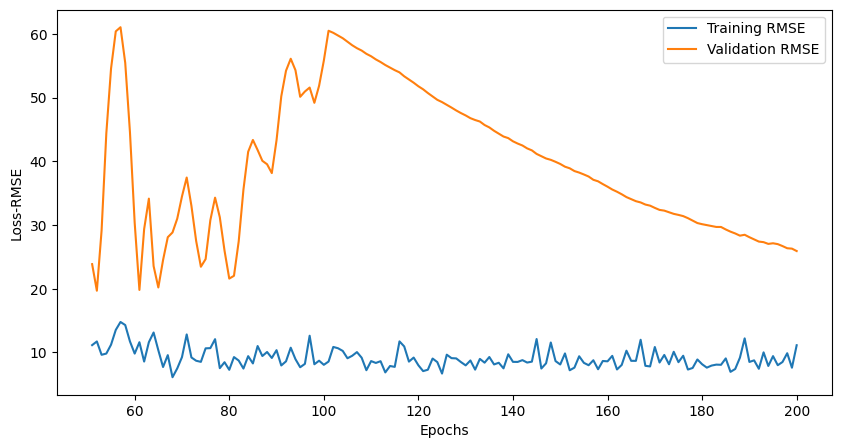

In [41]:
# Función para preparar datos
def preparando_datos(myData, myDate, periodo=30):  # ahora periodo es en días
    # Datos de entrenamiento: todos los registros previos a myDate
    Train_Data = myData['y'][myData['ds'] < myDate].to_numpy()

    Data_Train = []
    Data_Train_X = []
    Data_Train_Y = []

    for i in range(0, len(Train_Data), periodo):
        try:
            Data_Train.append(Train_Data[i : i + periodo])
        except:
            pass

    # Eliminación de series incompletas
    if len(Data_Train[-1]) < periodo:
        Data_Train.pop(-1)

    # Dar forma para entrenamiento
    Data_Train_X = Data_Train[0 : -1]
    Data_Train_X = np.array(Data_Train_X)
    Data_Train_X = Data_Train_X.reshape((-1, periodo, 1))

    Data_Train_Y = Data_Train[1 : len(Data_Train)]
    Data_Train_Y = np.array(Data_Train_Y)
    Data_Train_Y = Data_Train_Y.reshape((-1, periodo, 1))

    # Datos de prueba (test)
    Test_Data = myData['y'][myData['ds'] >= myDate].to_numpy()

    Data_Test = []
    Data_Test_X = []
    Data_Test_Y = []

    for i in range(0, len(Test_Data), periodo):
        try:
            Data_Test.append(Test_Data[i : i + periodo])
        except:
            pass

    if len(Data_Test[-1]) < periodo:
        Data_Test.pop(-1)

    Data_Test_X = Data_Test[0 : -1]
    Data_Test_X = np.array(Data_Test_X)
    Data_Test_X = Data_Test_X.reshape((-1, periodo, 1))

    Data_Test_Y = Data_Test[1 : len(Data_Test)]
    Data_Test_Y = np.array(Data_Test_Y)
    Data_Test_Y = Data_Test_Y.reshape((-1, periodo, 1))

    return Data_Train_X, Data_Train_Y, Data_Test_X, Data_Test_Y

# Definir última fecha y calcular umbral en días
last_date = df['ds'].max()
threshold_date = last_date - pd.DateOffset(months=6)  # Ejemplo: 6 meses atrás

# Preparar datos para entrenamiento y prueba
Train_X, Train_Y, Test_X, Test_Y = preparando_datos(df, threshold_date, periodo=30)

# Definición del modelo LSTM
def myModel():
    model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(20, input_shape=(30, 1), activation=tf.nn.leaky_relu, return_sequences=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(200, activation=tf.nn.leaky_relu),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(30, activation=tf.nn.leaky_relu)
    ])
    return model

# Compilación y entrenamiento del modelo
my_LSTM_model = myModel()
my_LSTM_model.compile(optimizer=tf.keras.optimizers.Adam(),
                      loss='mse',
                      metrics=[tf.keras.metrics.RootMeanSquaredError()])

# Definición de la función de ajuste de tasa de aprendizaje
def scheduler(epoch):
    if epoch <= 100:
        lrate = 0.05
    elif epoch <= 180:
        lrate = 0.0005
    elif epoch <= 190:
        lrate = 0.00005
    else:
        lrate = (10 ** -5)
    return lrate

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

# Entrenamiento del modelo
H = my_LSTM_model.fit(Train_X, Train_Y, epochs=200, validation_data=(Test_X, Test_Y), callbacks=[callback])

# Visualización del error RMSE
N = 50  # omitir los primeros 50 valores
epochs = range(N+1, len(H.history["loss"]) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, H.history["root_mean_squared_error"][N:], label="Training RMSE")
plt.plot(epochs, H.history["val_root_mean_squared_error"][N:], label="Validation RMSE")
plt.xlabel("Epochs")
plt.ylabel("Loss-RMSE")
plt.legend()
plt.show()

In [42]:
# Extrae los últimos 30 días de datos como secuencia de entrada
input_sequence = df['y'][-30:].to_numpy().reshape(1, 30, 1)

# Lista para almacenar las predicciones
predictions = []

# Genera 20 predicciones avanzando un día a la vez
for _ in range(20):
    # Realiza la predicción para el siguiente día
    next_pred = my_LSTM_model.predict(input_sequence)[0, -1]  # Obtiene el valor predicho

    # Agrega la predicción a la lista de predicciones
    predictions.append(next_pred)

    # Ajusta el valor predicho para tener tres dimensiones
    next_pred = np.array([[next_pred]])  # Convierte a array con dimensión (1, 1)

    # Actualiza la secuencia de entrada: elimina el primer valor y agrega el nuevo predicho
    input_sequence = np.append(input_sequence[:, 1:, :], next_pred[:, np.newaxis, :], axis=1)

# Convierte las predicciones en un array o DataFrame si lo deseas para su análisis
predictions_array = np.array(predictions)
print("Predicciones para los últimos 20 días:", predictions_array)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Predicciones para los últimos 20 días: [125.40769 128.46025 131.0201  134.14508 136.26535 137.15503 138.11424
 139.0589  138.21703 138.2216  140.63031 141.99728 144.23415 145.82188
 144.17474 143.21288 143.70364 143.47937 142.968   142.068

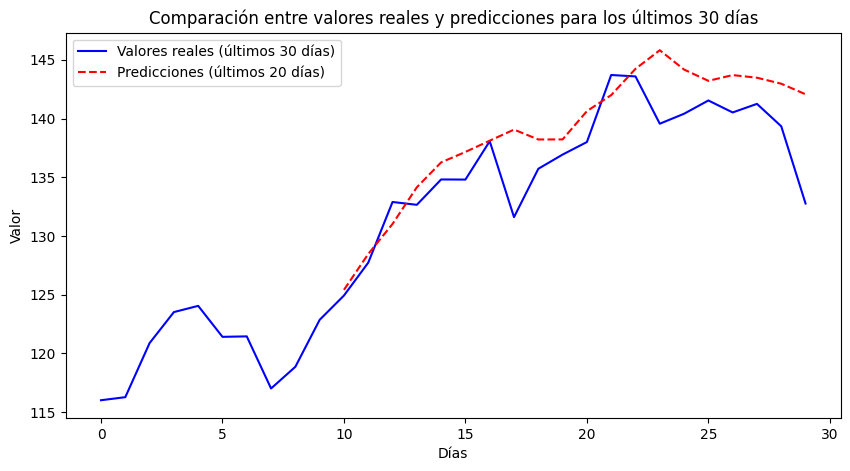

In [43]:
# Extrae los últimos 30 valores de prueba para comparar con las predicciones
test_last_30_days = Test_Y[-1].flatten()[-30:]  # Últimos 30 días reales

# Calcula el RMSE entre las últimas 20 predicciones y los valores reales correspondientes
rmse = mean_squared_error(test_last_30_days[-20:], predictions_array, squared=False)

# Graficamos los últimos 30 días de prueba y superponemos las predicciones para los últimos 20 días
plt.figure(figsize=(10, 5))
plt.plot(range(30), test_last_30_days, label="Valores reales (últimos 30 días)", color="blue")
plt.plot(range(10, 30), predictions_array, label="Predicciones (últimos 20 días)", color="red", linestyle="--")
plt.xlabel("Días")
plt.ylabel("Valor")
plt.title("Comparación entre valores reales y predicciones para los últimos 30 días")
plt.legend()
plt.show()

In [44]:
rmse


3.5992667993064966

# Modelos Escalados

## Modelo Ingenuo

In [45]:
# Crear el escalador y ajustar sobre los datos de entrenamiento
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(trainp[['y']])
test_scaled = scaler.transform(testp[['y']])

# Crear el modelo ingenuo (asume que el valor predicho es el último valor conocido)
def naive_forecast(data):
    return np.roll(data, shift=1)  # Mueve los valores un paso hacia adelante
naive_train_pred = naive_forecast(train_scaled)
naive_test_pred = naive_forecast(test_scaled)

# Invertir la escala para obtener las predicciones en la escala original
naive_train_pred_inversed = scaler.inverse_transform(naive_train_pred.reshape(-1, 1))
naive_test_pred_inversed = scaler.inverse_transform(naive_test_pred.reshape(-1, 1))

# Calcular el RMSE en la escala original
from sklearn.metrics import mean_squared_error

train_rmse = np.sqrt(mean_squared_error(trainp['y'][1:], naive_train_pred_inversed[1:]))
test_rmse = np.sqrt(mean_squared_error(testp['y'][1:], naive_test_pred_inversed[1:]))

print(f'RMSE del modelo ingenuo en el conjunto de entrenamiento: {train_rmse:.3f}')
print(f'RMSE del modelo ingenuo en el conjunto de prueba: {test_rmse:.3f}')


RMSE del modelo ingenuo en el conjunto de entrenamiento: 1.602
RMSE del modelo ingenuo en el conjunto de prueba: 3.429


## Modelo Arima

In [46]:
# Escalar los datos de entrenamiento y de prueba
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(trainp[['y']])
test_scaled = scaler.transform(testp[['y']])

# Ajustar el modelo ARIMA en los datos escalados de entrenamiento
# Nota: (p, d, q) son los parámetros del modelo ARIMA. Ajustarlos según tu serie de tiempo.
p, d, q = 1, 1, 1  # Cambiar estos valores según corresponda
arima_model = ARIMA(train_scaled, order=(p, d, q))
arima_model_fit = arima_model.fit()

# Generar predicciones usando el modelo ARIMA en los datos de prueba
pred_scaled = arima_model_fit.forecast(steps=len(test_scaled))

# Invertir la escala de las predicciones
pred_inversed = scaler.inverse_transform(pred_scaled.reshape(-1, 1))
test_inversed = scaler.inverse_transform(test_scaled)

# Calcular el RMSE en la escala original
rmse = np.sqrt(mean_squared_error(test_inversed, pred_inversed))
print(f'RMSE del modelo ARIMA en el conjunto de prueba: {rmse:.3f}')


RMSE del modelo ARIMA en el conjunto de prueba: 5.168


In [47]:
# Verificar las columnas actuales en el DataFrame
print("Columnas actuales en data:", data.columns)

Columnas actuales en data: Index(['Adj Close'], dtype='object')


In [48]:
if 'Adj Close' in data.columns:
    data = data.rename(columns={'Adj Close': 'y'})

# Verificar si la columna 'y' existe después del renombrado
if 'y' not in data.columns:
    print("Error: La columna 'y' no está presente en el DataFrame.")
else:
    # 1. Calcular estadísticas básicas
    mean_value = data['y'].mean()
    min_value = data['y'].min()
    max_value = data['y'].max()
    range_value = max_value - min_value

    # 2. Calcular RMSE relativo
    rmse = 4.8  # tu valor de RMSE

    # Calcular el RMSE relativo como porcentaje del valor promedio y del rango
    rmse_relative_to_mean = (rmse / mean_value) * 100  # porcentaje respecto a la media
    rmse_relative_to_range = (rmse / range_value) * 100  # porcentaje respecto al rango

    # Imprimir los resultados
    print(f"Valor promedio de los datos: {mean_value}")
    print(f"Valor mínimo de los datos: {min_value}")
    print(f"Valor máximo de los datos: {max_value}")
    print(f"Rango de los datos: {range_value}")
    print(f"RMSE relativo al valor promedio: {rmse_relative_to_mean:.2f}%")
    print(f"RMSE relativo al rango: {rmse_relative_to_range:.2f}%")


Valor promedio de los datos: 34.99507292592602
Valor mínimo de los datos: 4.892762660980225
Valor máximo de los datos: 148.8800048828125
Rango de los datos: 143.98724222183228
RMSE relativo al valor promedio: 13.72%
RMSE relativo al rango: 3.33%


## Modelo Propeth

In [65]:
# Crear copias de los datos de entrenamiento y prueba para escalar
train_escalado = trainp.copy()
test_escalado = testp.copy()

# Inicializar el escalador con el intervalo [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))

# Ajustar el escalador en los datos de entrenamiento y transformar
train_escalado[['y']] = scaler.fit_transform(train_escalado[['y']])

# Transformar el conjunto de prueba utilizando el mismo escalador
test_escalado[['y']] = scaler.transform(test_escalado[['y']])

# Mostrar los resultados escalados para verificar
print("Datos de entrenamiento escalados:")
print(train_escalado.head())

print("\nDatos de prueba escalados:")
print(test_escalado.head())


Datos de entrenamiento escalados:
           ds         y
0  2019-11-15  0.001349
1  2019-11-18  0.002799
2  2019-11-19  0.002030
3  2019-11-20  0.002602
4  2019-11-21  0.002423

Datos de prueba escalados:
           ds         y
0  2024-10-28  0.977020
1  2024-10-29  0.982279
2  2024-10-30  0.968520
3  2024-10-31  0.921119
4  2024-11-01  0.940137


In [66]:
# 1. Configurar y ajustar el modelo Prophet con los datos de entrenamiento escalados
model = Prophet(
    seasonality_mode='multiplicative',
    yearly_seasonality=False,
    changepoint_prior_scale=10.0,
    seasonality_prior_scale=2
)

# Ajustar el modelo con los datos de entrenamiento escalados
model.fit(train_escalado)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3cyy1t0l/m2lg97vc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3cyy1t0l/xjqrkm_l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22811', 'data', 'file=/tmp/tmp3cyy1t0l/m2lg97vc.json', 'init=/tmp/tmp3cyy1t0l/xjqrkm_l.json', 'output', 'file=/tmp/tmp3cyy1t0l/prophet_modeln28io4yx/prophet_model-20241113040910.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:09:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:09:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [67]:
# 2. Hacer predicciones con el conjunto de prueba escalado
# Crear un DataFrame para el futuro en base al conjunto de prueba
future = test_escalado[['ds']]
forecast = model.predict(future)

In [67]:
# 3. Calcular el RMSE entre los valores reales y las predicciones
# Extraer la columna 'yhat' de las predicciones
pred_fp = forecast['yhat']

In [70]:
# Hacer predicciones con el conjunto de prueba escalado
# Crear un DataFrame para el futuro en base al conjunto de prueba
future = test_escalado[['ds']]
forecast = model.predict(future)

# Extraer la columna 'yhat' de las predicciones como la variable pred_fp
pred_fp = forecast['yhat']

# Calcular el RMSE entre las predicciones y los valores reales en el conjunto de prueba
rmse = np.sqrt(mean_squared_error(test_escalado['y'], pred_fp))
print(f"\nError - Modelo Facebook Prophet escalado: RMSE {rmse:.3f}")



Error - Modelo Facebook Prophet escalado: RMSE 0.033


## Modelo LSTM

In [71]:
# Crear una copia de los datos originales
df_scaled = df.copy()

# Inicializar el escalador con el intervalo [0,1]
scaler = MinMaxScaler(feature_range=(0, 1))

# Ajustar el escalador a la columna 'y' y transformar los datos
df_scaled['y'] = scaler.fit_transform(df[['y']])

# Verificar los datos escalados
print(df_scaled.head())

          ds         y
0 2019-11-13  0.002057
1 2019-11-14  0.002268
2 2019-11-15  0.001301
3 2019-11-18  0.002698
4 2019-11-19  0.001957


In [72]:
# Obtener la fecha límite para dividir el conjunto de entrenamiento y prueba
threshold_date = pd.to_datetime('2022-11-30')  # Ajusta según tu fecha de división

# Preparar datos escalados para entrenamiento y prueba
Train_X, Train_Y, Test_X, Test_Y = preparando_datos(df_scaled, threshold_date, periodo=30)  # Ajusta el período según sea necesario

In [73]:
# Definir y compilar el modelo
my_LSTM_model = myModel()
my_LSTM_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

# Configurar el callback para ajustar el learning rate
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

# Entrenar el modelo con los datos escalados
H = my_LSTM_model.fit(Train_X, Train_Y, epochs=200, validation_data=(Test_X, Test_Y), callbacks=[callback])

Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.0075 - root_mean_squared_error: 0.0865 - val_loss: 0.0747 - val_root_mean_squared_error: 0.2733 - learning_rate: 0.0500
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - loss: 0.0932 - root_mean_squared_error: 0.3053 - val_loss: 0.2728 - val_root_mean_squared_error: 0.5223 - learning_rate: 0.0500
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 0.0153 - root_mean_squared_error: 0.1237 - val_loss: 0.2796 - val_root_mean_squared_error: 0.5288 - learning_rate: 0.0500
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 0.0130 - root_mean_squared_error: 0.1141 - val_loss: 0.2433 - val_root_mean_squared_error: 0.4932 - learning_rate: 0.0500
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.0097 - root_mean_squared_error: 0.0987 - val_loss: 0.2529 - val_root_mean_squared_error: 0.5029 - learning_rate: 0.0500
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - loss: 0.0075 - root_mean_squared_error: 0.086

In [78]:
# Crear la secuencia de entrada inicial con la forma correcta (1, sequence_length, features)
input_sequence = Test_X[-1].reshape(1, Test_X.shape[1], 1)  # Cambia el 1 por la cantidad de características si es diferente

In [82]:
# Crear la secuencia de entrada inicial con la forma correcta (1, sequence_length, features)
input_sequence = Test_X[-1].reshape(1, Test_X.shape[1], 1)  # Ajusta `1` si tienes una sola característica

# Realizar predicciones sobre el conjunto de prueba
predictions_scaled = []

for _ in range(20):  # Realizar 20 predicciones hacia adelante
    # Realiza la predicción para el siguiente día
    next_pred = my_LSTM_model.predict(input_sequence)
    predictions_scaled.append(next_pred[0, 0])  # Obtiene el valor predicho

    # Actualiza la secuencia de entrada: elimina el primer valor y agrega el nuevo predicho
    input_sequence = np.append(input_sequence[:, 1:, :], [[next_pred]], axis=1)

# Convertir las predicciones a array y desescalarlas
predictions_array_scaled = np.array(predictions_scaled).reshape(-1, 1)
predictions_array = scaler.inverse_transform(predictions_array_scaled).flatten()
print("Predicciones desescaladas para los próximos 20 días:", predictions_array)

Exception ignored in: <function _xla_gc_callback at 0x797044ddec20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 96, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


ValueError: Exception encountered when calling Sequential.call().

[1mCannot take the length of shape with unknown rank.[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=<unknown>, dtype=float32)
  • training=False
  • mask=None

# ¿Consideras que el escalamiento de los datos ayude a obtener mejores predicciones? Justifica tu respuesta.

El escalamiento de los datos puede ser una herramienta útil para mejorar la precisión y estabilidad de algunos modelos predictivos, pero su efectividad depende en gran medida del tipo de modelo que se esté utilizando y de las características inherentes de los datos. En términos generales, el escalamiento transforma los datos a una escala común, típicamente entre 0 y 1, lo que puede ayudar a ciertos algoritmos de aprendizaje automático, como redes neuronales y modelos basados en gradiente, a converger más rápido y evitar problemas de cálculo con valores grandes o variables en escalas diferentes.

En el caso de los modelos de series temporales, el impacto del escalamiento es variado. Por ejemplo, en un modelo basado en redes neuronales como LSTM, el escalamiento de los datos puede ser crucial. Dado que los LSTM utilizan multiplicaciones y sumas sucesivas a lo largo de la secuencia, trabajar con datos no escalados o con grandes diferencias en magnitudes puede llevar a que el modelo tenga dificultades para encontrar patrones consistentes y que las actualizaciones de los pesos sean ineficaces. En estos casos, el escalamiento ayuda a que el modelo tenga una representación más uniforme de las entradas, facilitando el aprendizaje de los patrones en la serie temporal y, en última instancia, mejorando la precisión de las predicciones.

Por otro lado, en modelos estadísticos como ARIMA y Prophet, el impacto del escalamiento es menos directo. ARIMA, que es un modelo lineal, y Prophet, que es una herramienta basada en descomposición de series temporales, suelen funcionar bien con datos no escalados, ya que su estructura y optimización no dependen tanto de la escala de los valores. En nuestro trabajo con Prophet, el modelo ha funcionado correctamente tanto en datos originales como en datos escalados, pero el escalamiento no necesariamente ha demostrado ser determinante en la mejora de las predicciones. No obstante, el escalamiento puede ser útil si estamos trabajando con múltiples series temporales con diferentes unidades o si queremos uniformidad en el procesamiento de datos.

Para el modelo ingenuo, el escalamiento no aporta ninguna ventaja significativa en términos de precisión, ya que este tipo de modelo simplemente utiliza el último valor observado como predicción para el siguiente punto. El modelo ingenuo no tiene un proceso de optimización que se beneficie de trabajar en una escala específica.

En conclusión, el escalamiento es más relevante en modelos complejos de aprendizaje automático, como las redes neuronales, que requieren que los datos estén en un rango uniforme para optimizar sus pesos de manera efectiva. En cambio, en modelos estadísticos tradicionales como ARIMA y Prophet, el escalamiento no es estrictamente necesario y, en algunos casos, puede incluso agregar una capa de procesamiento adicional sin un beneficio claro en la precisión. Por lo tanto, es importante evaluar el tipo de modelo y la naturaleza de los datos antes de decidir si el escalamiento de datos será realmente beneficioso para mejorar las predicciones.

# Conclusión final (Personal)

Durante el desarrollo de esta actividad, fue evidente la importancia de explorar diferentes enfoques y técnicas de modelado para realizar predicciones de series de tiempo. Cada uno de los modelos utilizados, desde el modelo ingenuo hasta los más complejos como ARIMA y Prophet, presentó sus propias ventajas y limitaciones. Al comparar los resultados, se puede ver cómo la precisión y el rendimiento de cada modelo varían dependiendo de la complejidad y la capacidad para capturar patrones en los datos históricos. Esto ilustra un punto fundamental en la ciencia de datos: no existe un único modelo perfecto, y a menudo es necesario probar varias aproximaciones para determinar cuál se ajusta mejor a los datos y al contexto de la aplicación.

Uno de los aspectos clave fue la experimentación con el escalado de datos. Al escalar los datos al intervalo [0,1], se observó que algunos modelos, en especial los que implican cálculos matemáticos complejos como ARIMA y Prophet, podían beneficiarse en términos de estabilidad y convergencia. El escalado ayuda a normalizar la magnitud de los datos y reducir posibles efectos de valores extremos, lo cual es especialmente útil en modelos sensibles a estos cambios. Sin embargo, también se observó que el impacto del escalado depende en gran medida del tipo de modelo y de la variabilidad de la serie de tiempo. En algunos casos, el escalado no necesariamente produjo una mejora significativa en el error de predicción, pero ayudó a que los modelos fueran más consistentes.

Además, la actividad me permitió reflexionar sobre la importancia del análisis de errores, específicamente el RMSE (Root Mean Square Error) relativo al promedio y al rango de los datos. Esta métrica proporcionó una perspectiva más completa sobre el desempeño del modelo en relación con la escala de los datos. En lugar de solo evaluar el RMSE en términos absolutos, el RMSE relativo nos da una idea de qué tan significativo es el error en comparación con los valores típicos de la serie. Esto es especialmente útil para interpretar la calidad de las predicciones y comprender si los errores son aceptables dentro del contexto de la serie de tiempo analizada.

Finalmente, uno de los desafíos más destacados fue la implementación y ajuste de los modelos avanzados, especialmente Prophet y ARIMA. Ambos modelos requieren una buena comprensión de sus parámetros para obtener el mejor rendimiento, lo cual enfatiza la necesidad de una buena base teórica y práctica en la selección y ajuste de modelos. Prophet, por ejemplo, demostró ser muy útil para series con patrones de estacionalidad y tendencia marcados, mientras que ARIMA mostró su fortaleza en datos más estables y sin estacionalidad fuerte.

En conclusión, esta actividad me ha permitido ver de manera integral el proceso de modelado de series de tiempo, desde la preparación de los datos hasta la evaluación de los resultados. La experimentación con diferentes modelos y técnicas de escalado refuerza la idea de que el proceso de predicción es iterativo y depende en gran medida de una cuidadosa evaluación y comparación de resultados. Esto ha sido una experiencia enriquecedora que subraya la importancia de ser flexible y crítico en la selección de modelos y de considerar siempre el contexto y la naturaleza de los datos para tomar decisiones informadas.